**This is the notebook for classifying or detecting objects from the image using SAM and CLIP**
* First segment the image and get all the bounding boxes
* Cropped the image area using bounding box
* Pass that bounding box to CLIP model by giving the labels that you want to identify or classify
* By setting some threshold you can classify the image or get the object of interest
* You can use this for generating the data object detection model training data.

In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
# ! wget <uri> -P /path/to/folder

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-9f7ux24t
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-9f7ux24t
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 823.0 kB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369501 sha256=c6e0138878965d4e3098a045a45cff2ccb06f9f780fa01cf03be666c01e04f4b
  Stored in directory: /tmp/pip-ephem-wheel-cache-y7r2wobo/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import shutil
import torch
import clip
from PIL import Image
from itertools import islice

In [ ]:
def draw_bounding_box(image, bbox, color=(0, 255, 0), thickness=2):
    x, y, w, h = bbox
    cv2.rectangle(image, (x, y), (x + w, y + h), color, thickness)

In [ ]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

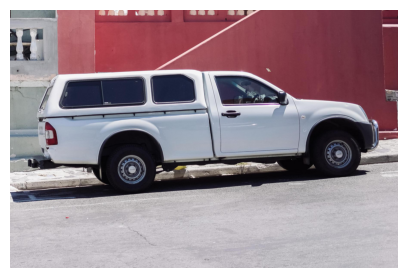

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
#Model loading and setting
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
masks = mask_generator.generate(image)

In [ ]:
masks[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 632681,
 'bbox': [86, 282, 1621, 566],
 'predicted_iou': 1.039663553237915,
 'point_coords': [[1378.125, 581.25]],
 'stability_score': 0.9835065603256226,
 'crop_box': [0, 0, 1800, 1200]}

In [ ]:
#Display all the generated bounding boxes
for m in masks:
  # Bounding box coordinates (x, y, width, height)
  bbox = tuple(m['bbox'])
  draw_bounding_box(image, bbox)
cv2_imshow(image)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
mkdir croppedBoxes

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"
def get_model():
      model, preprocess = clip.load("ViT-B/32", device=device)
      return model, preprocess
def get_prediction(frame_path, list_of_labels, how_many_predictions, model, preprocess) -> list:
    Highest3Predictions = []
    try:
        text = clip.tokenize(list_of_labels).to(device)
        image = preprocess(Image.open(frame_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
            probs = probs.tolist()[0]
        vv = {}
        for i, j in enumerate(probs):
            vv[list_of_labels[i]] = j
        maxx = {k: v for k, v in sorted(vv.items(), key=lambda item: item[1], reverse=True)}
        Highest3Predictions = list(islice(maxx.items(), how_many_predictions))
        print(f"{frame_path} : {Highest3Predictions}")
    except:
        pass

    return Highest3Predictions

In [ ]:
model, preprocess = get_model()

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 105MiB/s]


In [ ]:
list_of_labels = ["a photo of a truck", "a photo of a bottle", "a photo of a glass",
                  "a photo of "]
how_many_predictions = 2
image_path = "images/truck.jpg"

In [ ]:
Highest3Predictions = get_prediction(image_path, list_of_labels, how_many_predictions, model, preprocess)

images/truck.jpg : [('a photo of a truck', 0.974609375), ('a photo of ', 0.0247802734375)]


In [ ]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
for aa, m in enumerate(masks):
  bbox = tuple(m['bbox'])
  # x1, y1, x2, y2 = bbox
  x, y, width, height = bbox
  if height >= 50 and width >= 50:
    cropped_image = image[y:y+height, x:x+width]
    # cropped_image = image[y1:y2, x1:x2]
    cv2.imwrite("croppedBoxes/" + str(aa) + ".jpg", cropped_image)
    Highest3Predictions = get_prediction("croppedBoxes/" + str(aa) + ".jpg", list_of_labels, how_many_predictions, model, preprocess)
    cv2_imshow(cropped_image)
    print("________________")

Output hidden; open in https://colab.research.google.com to view.